# Part 2: Spotify Project

Author: Cristobal Zamorano Astudillo

## Introduction & Recap on Part 1

Previouly, in Part 1, we tried to handed a dataset without explicit instructions on what to do with it. Our dataset was a collection of metrics that Spotify uses for their music streaming platforms. Without a specific desired outcome, we attempted to automatically find structutre in the data by extracting useful features and analyzing its structure.

In order to understand and organize the data we used the Principal Component Analysis. Using this Dimensional Reduction algorithm, we found interesting things:
- Using the Covaraince Matrix we realized that the Time Feature Extractions that we did in EDA prior to PCA, were carrying too much correlation within similar Time features. So, we drop them for PCA purposes.
- After running our PCA algorithm, we found that the Liked Music and No-Liked music are way too similar in terms of modeling without a supervision. This means that cross-prediction of True-False and False-True results are very likely to happen without a test dataset to comparer themselves.
- Also, we found that some features are certainly more important than others therefore we can later on compare the features importance of PCA with other algortihms

##### Now what?

PCA stands for Principal Component "Analysis". As it is mentioned in its name, this algorithm aimes on better understanding the data set and its features. Nevertheless, one can use the resulted data set in lower dimensions for the classification with no problem.

While using PCA, be aware of the effects of the high variance features on the results. This feature or features may have no information on them and may mislead you and your classifier to nowhere. Imagine the noise in the data (signal noise) that will come up as the most important feature by PCA but, actually, it is worthless. 

Therefore, **the goal of this Part 2** is to compare classification algorithms with and without dimensionality reduction.

In [2]:
# Data Manipulation 
import pandas as pd

# Linear Algebra and Math
import numpy as np
from scipy import interp
import math
from scipy.stats import norm
from scipy import stats

# 2D Visualizations
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from matplotlib.ticker import MaxNLocator



# 3D Visualizations
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
from plotly.offline import iplot
import plotly as py

# Decisiton Tree
import pydotplus
import io
import graphviz
from scipy import misc
import imageio

# from matplotlib.colors import DivergingNorm

%matplotlib inline

In [3]:
# I'm a big fan of  https://fivethirtyeight.com/ and their visualizations :) 
style.use('fivethirtyeight') 
# grid: rgb(240,240,240)
# background: rgb(200,200,200)

In [4]:
my_songs_df = pd.read_csv("./output/project_data/my_songs_clean.csv")
my_songs_df.head()

Unnamed: 0    song_name           endTime         artist  msPlayed  \
0           6  La La Latch  2020-02-07 14:12     Pentatonix    189852   
1           9  Lejos De Ti  2020-02-07 14:14  Shamanes Crew    111980   
2          24       Perdón  2020-02-07 14:18     Mike Bahía    195554   
3          33   Dos Mundos  2020-02-07 14:21          Reyno    183789   
4          34      アウトサイダー  2020-02-07 14:25          SymaG    207600   

              datetime  danceability  energy  key  loudness  ...  Year  \
0  2020-02-07 14:12:00         0.694   0.512    6    -8.719  ...  2020   
1  2020-02-07 14:14:00         0.666   0.725    9    -6.114  ...  2020   
2  2020-02-07 14:18:00         0.658   0.880   11    -3.472  ...  2020   
3  2020-02-07 14:21:00         0.634   0.520    5    -9.804  ...  2020   
4  2020-02-07 14:25:00         0.526   0.885    6    -2.189  ...  2020   

   Week_of_Year  Day_of_Year  Quarter  Season  Season_Numeric  Day_Numeric  \
0             6           38        1  Winter               1            5   
1             6           38        1  Winter               1            5   
2             6           38        1  Winter               1            5   
3             6           38        1  Winter               1            5   
4             6           38        1  Winter               1            5   

   exists  liked counts_per_song  
0    True      1           104.0  
1    True      1            95.0  
2    True      1            77.0  
3    True      1            65.0  
4    True      1            65.0  

[5 rows x 33 columns]

In [5]:
# Missing values
def missing_values_func(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
            columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
        # Returns
        if mis_val_table_ren_columns.empty:
            return f'Your selected dataframe has  {df.shape[1]} features. There are  {mis_val_table_ren_columns.shape[0]} features that have missing values.'
        else:
            display(mis_val_table_ren_columns.style.background_gradient(cmap='Reds'))
            return f'Your selected dataframe has  {df.shape[1]} features. There are  {mis_val_table_ren_columns.shape[0]} features that have missing values.'
        
missing_values_func(my_songs_df)

'Your selected dataframe has  33 features. There are  1 features that have missing values.'

In [6]:
features_scores_df = pd.read_csv('./output/project_data/pca/features_metrics_spotify.csv')
features_scores_df.set_index('Unnamed: 0', inplace = True)
features_scores_df.index.rename(None, inplace = True)
display(features_scores_df.shape)
display(missing_values_func(features_scores_df))
features_scores_df.head()

(13, 7)

'Your selected dataframe has  7 features. There are  0 features that have missing values.'

PC1       PC2       PC3       PC4       PC5       PC6  \
danceability  0.170899  0.591721 -0.251406 -0.104466  0.256516 -0.210032   
energy        0.467570 -0.226617 -0.005841  0.001844 -0.010053  0.032110   
key           0.058073  0.135264  0.351547  0.317715  0.424163  0.581492   
loudness      0.480108 -0.013989 -0.022348 -0.032145 -0.032684  0.050627   
mode         -0.028089 -0.122110 -0.240066 -0.668718 -0.207499  0.175257   

                   PC7  
danceability -0.097227  
energy        0.090067  
key          -0.465772  
loudness     -0.011202  
mode         -0.575407

In [7]:
songs_projections_df = pd.read_csv('./output/project_data/pca/eigenvectors_liked_dislike_music.csv')
songs_projections_df.set_index('Unnamed: 0', inplace = True)
songs_projections_df.index.rename(None, inplace = True)
display(songs_projections_df.shape)
display(missing_values_func(songs_projections_df))
songs_projections_df.head()

(19862, 8)

'Your selected dataframe has  8 features. There are  0 features that have missing values.'

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.113416  0.473711 -0.176854  1.095969  0.114266  0.073117  0.468971   
1  0.455824  0.691162 -1.271580  0.026448  0.704925  0.865490 -1.093169   
2  1.805198  1.156876  1.140292  1.693472  0.263038 -0.125954 -0.659176   
3 -1.038316  0.362909 -0.172231 -0.655079 -0.748532  0.506294 -0.301523   
4  1.817173  0.082959  0.557898  1.413634 -0.620873 -0.230464  0.339411   

  Type_of_Song  
0        Liked  
1        Liked  
2        Liked  
3        Liked  
4        Liked

In [8]:
target = my_songs_df['liked']
# songs_projections_df.drop(columns=['Type_of_Song'], inplace=True)
# songs_projections_df.shape

In [9]:
weekly_df = pd.read_csv('./output/project_data/weekly_discover_final.csv')
weekly_df.set_index('Unnamed: 0', inplace = True)
weekly_df.index.rename(None, inplace = True)
display(weekly_df.shape)
display(missing_values_func(weekly_df))
display(weekly_df.head())
weekly_df.drop(columns = ['artist','album','song_name'], inplace = True)
display(weekly_df.shape)
weekly_df.head()

(30, 16)

'Your selected dataframe has  16 features. There are  0 features that have missing values.'

artist                         album  \
0                    Porta                      Libérate   
1  Destripando la Historia                        Hestia   
2            Brian the Sun  Lonely Go! (Another Edition)   
3                Say Ocean                  Primer Lugar   
4                    Alvei          Summertime Trap Ver.   

              song_name  danceability  energy  key  loudness  mode  \
0              Libérate         0.755   0.808    7    -6.591     1   
1                Hestia         0.858   0.574    6    -5.931     1   
2            Lonely Go!         0.477   0.979    8    -1.650     1   
3          Primer Lugar         0.668   0.942   10    -1.859     0   
4  Summertime Trap Ver.         0.846   0.366    9    -8.304     1   

   speechiness  instrumentalness  liveness  valence    tempo  duration_ms  \
0       0.3790           0.00000    0.0816    0.525   92.262       182870   
1       0.0632           0.00000    0.3010    0.938  121.998       212828   
2       0.0933           0.00000    0.3330    0.449  102.036       238507   
3       0.1340           0.00000    0.0955    0.813  147.997       212939   
4       0.1910           0.00257    0.0837    0.873  125.129       123115   

   time_signature  acousticness  
0               4      0.135000  
1               4      0.460000  
2               4      0.000081  
3               4      0.044000  
4               4      0.028100

(30, 13)

danceability  energy  key  loudness  mode  speechiness  instrumentalness  \
0         0.755   0.808    7    -6.591     1       0.3790           0.00000   
1         0.858   0.574    6    -5.931     1       0.0632           0.00000   
2         0.477   0.979    8    -1.650     1       0.0933           0.00000   
3         0.668   0.942   10    -1.859     0       0.1340           0.00000   
4         0.846   0.366    9    -8.304     1       0.1910           0.00257   

   liveness  valence    tempo  duration_ms  time_signature  acousticness  
0    0.0816    0.525   92.262       182870               4      0.135000  
1    0.3010    0.938  121.998       212828               4      0.460000  
2    0.3330    0.449  102.036       238507               4      0.000081  
3    0.0955    0.813  147.997       212939               4      0.044000  
4    0.0837    0.873  125.129       123115               4      0.028100

## Machine Learning Model Building Process

There are mainly two types of learning algorithms: **Unsupervised vs Supervised**

#### Supervised Learning

Recall your time at school when you were a kid. Think of your teacher as the output variable that you want to predict. The teacher will teach the students, in other words **the output variable will be teaching the algortihm to learn how to classify the data objects based on the output variable**. 

The error will adjust the parameter until we have a predictive model that can accurately predict the output variable.


#### Unsupervised Learning

You don't have a teacher or an output variable. They are self-organizing data map such as PCA. For example, in Part 1 we purposely didn't have an outcome to use PCA so we can freely explore the dimensions and see if we could use the dataset for a machine learning modeling without output variable to teach the dataset. As it was explained before, we couldn't get that results because the difference between Liked and No-Liked songs are too hard to differentiate without a supervised output variable.

### Classification vs Regression

Your output variable will be suitable of classification or regression depending on whether the output variable is quantitiative or qualitative value.

- If Quantitatiive or numeric output variable: **Use Regression**
- If Qualitative or categorical label output variable: **Use Classification**

Classification type can be **binary or multiclass**.

For this Spotify project, we previously constructed the `liked` feature, which is a feature of 1s (song added to the liked song playlist) and 0s (no added to the liked songs playlist). Thus, from now on we will be working on a **Supervised Classification Model**. We will be identifying which category a song should belong to using an testing dataset to compare to.

The testing dataset will be the "Weekly Playlist" from Spotify. We will be comparing the classification model using the Spotify features against their own weekly recomendation playlist.


### Splitting Data

The training data we downloaded is all the data we have available for both training models and validating the models that we train. We therefore need to split the training data into separate training and validation datsets. You will need this validation data to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every song.

#### Training set

We have the trained model and the cross-validated model.

In the Cross-validation model we will separate the dataset of the training set into $k$ number of folds, where a $k$ fold means the number of times we separate or partition the data. Each partition will have the roughly the same number of data samples. 

For example, if you have $150$ Iris flowers, then having a $10$ fold cross validation each fold will contain $15$ flowers. So, $15$ random flowers will be assigned to each of the ten partitions. In one iteration one partition will be left out and the remaining $9$ partition will be used to create the partition model.. and then the prediction model will be applied to the left out partition and so that concludes iteration one. Then the next iteration will then take the left out partition and move it back in and take a new partition out in order to use the remaining $9$ to create a prediction model and the apply the prediction model to predict the values of the left out partition. We do this over and over until each partition will be left out at least one time and then the prediction accuracy will be average of the $k$s iterations.

In the Trained model we use it to predict the y-values of the training sets and also the test sets


In [10]:
import warnings
warnings.filterwarnings(action='ignore')

## Classification Models

Machine learning models learn from data. It is crucial, however, that the data you feed them is specifically preprocessed and refined for the problem you want to solve. This includes data cleaning, preprocessing, feature engineering, and so on.

Very often, when presented with a dataset, I would fire up a Jupyter notebook and start exploring it interactively. The notebook is great for that task, but after a while I ended up with code that is a total mess in the global namespace

Therefore, we will be using the [Scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/), an open-source and efficient set of tools for predictive data analysis. Most of the algorithms will be imported from here.

We wil be also using [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/), two gradient boosting library. A gradient boosting is a machine learning technique used in either regression or classification modeling. It is specially helpful when dealing with weak learning models.

In addition, 

In [11]:
# Importing packages for modelling.

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, cross_validate, train_test_split, KFold
# from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

import xgboost as xgb
import lightgbm as lgb
from mlxtend.plotting import plot_decision_regions

In [28]:
metrics = my_songs_df[[
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms',
       'time_signature']].reset_index(drop=True)
X = metrics
y = target
X_test= weekly_df

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'X_test shape: {X_test.shape}')

X shape: (19862, 13)
y shape: (19862,)
X_test shape: (30, 13)


In [12]:
cv = StratifiedKFold(10, shuffle=True, random_state=42)

rf = RandomForestClassifier(criterion='gini',
                            n_estimators=1750,
                            max_depth=7,
                            min_samples_split=6,
                            min_samples_leaf=6,
                            max_features='auto',
                            oob_score=True,
                            random_state=42,
                            n_jobs=-1,
                            verbose=0)

lg = lgb.LGBMClassifier(max_bin=4,
                        num_iterations=550,
                        learning_rate=0.0114,
                        max_depth=3,
                        num_leaves=7,
                        colsample_bytree=0.35,
                        random_state=42,
                        n_jobs=-1)

xg = xgb.XGBClassifier(
    n_estimators=2800,
    min_child_weight=0.1,
    learning_rate=0.002,
    max_depth=2,
    subsample=0.47,
    colsample_bytree=0.35,
    gamma=0.4,
    reg_lambda=0.4,
    random_state=42,
    n_jobs=-1,
)

sv = SVC(probability=True)

logreg = LogisticRegression(n_jobs=-1, solver='newton-cg')

gb = GradientBoostingClassifier(random_state=42)

gnb = GaussianNB()

mlp = MLPClassifier(random_state=42)

In [13]:
estimators = [rf, lg, xg, gb, sv, logreg, gnb, mlp]

In [34]:
def model_check(X, y, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name
        #    model_table.loc[row_index, 'MLA Parameters'] = str(est.get_params())

        cv_results = cross_validate(
            est,
            X,
            y,
            cv=cv,
            scoring='accuracy',
            return_train_score=True,
            n_jobs=-1
        )

        model_table.loc[row_index, 'Train Accuracy Mean'] = cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test Accuracy Mean'] = cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test Accuracy Mean'],
                            ascending=False,
                            inplace=True)

    return model_table

In [37]:
# Plotting model performances
def model_barplot(models, bins):
    fig, ax = plt.subplots(figsize=(16, 8))
    g = sns.barplot('Test Accuracy Mean',
                    'Model Name',
                    data=models,
                    palette='plasma',
                    orient='h',
                    **{'xerr': models['Test Std']})
    g.set_xlabel('Test Mean Accuracy')
    g = g.set_title('Cross validation scores')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))

In [21]:
from sklearn import metrics



def m_roc(estimators, cv, X, y):

    fig, axes = plt.subplots(math.ceil(len(estimators) / 2),
                             2,
                             figsize=(25, 50))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i, (train, test) in enumerate(cv.split(X, y)):
            estimator.fit(X.loc[train], y.loc[train])
            viz = metrics.plot_roc_curve(estimator,
                                 X.loc[test],
                                 y.loc[test],
                                 name='ROC fold {}'.format(i),
                                 alpha=0.3,
                                 lw=1,
                                 ax=ax)
            interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        ax.plot([0, 1], [0, 1],
                linestyle='--',
                lw=2,
                color='r',
                label='Chance',
                alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax.plot(mean_fpr,
                mean_tpr,
                color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' %
                (mean_auc, std_auc),
                lw=2,
                alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr,
                        tprs_lower,
                        tprs_upper,
                        color='grey',
                        alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        ax.set(xlim=[-0.02, 1.02],
               ylim=[-0.02, 1.02],
               title=f'{estimator.__class__.__name__} ROC')
        ax.legend(loc='lower right', prop={'size': 18})
    plt.show()

In [40]:
def plot_learning_curve(estimators,
                        X,
                        y,
                        ylim=None,
                        cv=None,
                        n_jobs=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):

    fig, axes = plt.subplots(math.ceil(len(estimators) / 2),
                             2,
                             figsize=(25, 50))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):

        ax.set_title(f'{estimator.__class__.__name__} Learning Curve')
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.set_xlabel('Training examples')
        ax.set_ylabel('Score')

        train_sizes, train_scores, test_scores, fit_times, _ = \
            learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                           train_sizes=train_sizes,
                           return_times=True)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        # Plot learning curve

        ax.fill_between(train_sizes,
                        train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,
                        alpha=0.1,
                        color='r')
        ax.fill_between(train_sizes,
                        test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std,
                        alpha=0.1,
                        color='g')
        ax.plot(train_sizes,
                train_scores_mean,
                'o-',
                color='r',
                label='Training score')
        ax.plot(train_sizes,
                test_scores_mean,
                'o-',
                color='g',
                label='Cross-validation score')
        ax.legend(loc='best')
        ax.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.show()

In [15]:
def f_imp(estimators, X, y, bins):
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):

        try:
            estimator.fit(X, y)
            feature_imp = pd.DataFrame(sorted(
                zip(estimator.feature_importances_, X.columns)),
                                       columns=['Value', 'Feature'])

            sns.barplot(x="Value",
                        y="Feature",
                        data=feature_imp.sort_values(by="Value",
                                                     ascending=False),
                        ax=ax,
                        palette='plasma')
            plt.title('Features')
            plt.tight_layout()
            ax.set(title=f'{estimator.__class__.__name__} Feature Importances')
            ax.xaxis.set_major_locator(MaxNLocator(nbins=bins))
        except:
            continue
    plt.show()

In [18]:
def f_selector(X, y, est, features):
    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          y,
                                                          test_size=0.4,
                                                          random_state=42)

    # Create the RFE with a LogisticRegression estimator and 4 features to select
    rfe = RFE(estimator=est, n_features_to_select=features, verbose=1)

    # Fit the eliminator to the data
    rfe.fit(X_train, y_train)

    # Print the features and their ranking (high = dropped early on)
    print(dict(zip(X.columns, rfe.ranking_)))

    # Print the features that are not eliminated
    print(X.columns[rfe.support_])

    # Calculates the test set accuracy
    acc = accuracy_score(y_valid, rfe.predict(X_valid))
    print("{0:.1%} accuracy on test set.".format(acc))
    X_red = X[X_train.columns[rfe.support_].to_list()]
    X_te_red = X_test[X_train.columns[rfe.support_].to_list()]
    return X_red, X_te_red

In [21]:
def dec_regs(X, y, estimators):
    fig, axes = plt.subplots(math.ceil(len(estimators) / 2),
                             2,
                             figsize=(20, 40))

    axes = axes.flatten()

    for ax, estimator in zip(axes, estimators):
        estimator.fit(X, y.values)
        plot_decision_regions(X, y.values, clf=estimator,colors='#e00d14,#3ca02c',markers='x+', ax=ax)
        ax.set(title=f'Reg {estimator.__class__.__name__}')

        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles,
                  ['Not Survived', 'Survived'],
                  framealpha=0.3, scatterpoints=1)

    plt.show()

In [30]:
def prob_reg(X, y):
    from matplotlib.colors import ListedColormap
    figure = plt.figure(figsize=(20, 40))
    h = .02
    i = 1

    # preprocess dataset, split into training and test part
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X_sel_red[:, 0].min() - .5, X_sel_red[:, 0].max() + .5
    y_min, y_max = X_sel_red[:, 1].min() - .5, X_sel_red[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Just plot the dataset first
    cm = plt.cm.RdYlGn
    cm_bright = ListedColormap(['#e00d14', '#3ca02c'])
    ax = plt.subplot(5, 2, i)

    # Iterate over estimators
    for clf in estimators:
        ax = plt.subplot(math.ceil(len(estimators) / 2), 2, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        g = ax.scatter(X_train[:, 0],
                       X_train[:, 1],
                       c=y_train,
                       cmap=cm_bright,
                       edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0],
                   X_test[:, 1],
                   c=y_test,
                   cmap=cm_bright,
                   edgecolors='k',
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())

        ax.set_title(clf.__class__.__name__)
        #ax.text(xx.max() - .3,
        #        yy.min() + .3, (f'Score:{score:.2f}'),
        #        size=15,
        #        horizontalalignment='right')

        ax.set_xlabel('PCA 1')
        ax.set_ylabel('PCA 2')
        plt.legend(handles=g.legend_elements()[0],
                   labels=['Not Survived', 'Survived'],
                   framealpha=0.3,
                   scatterpoints=1)

        i += 1

    plt.tight_layout()
    plt.show()

### Week 1

We have a test set very small of 30 songs

In [18]:
raw_models = model_check(X, y, estimators, cv)
display(raw_models.style.background_gradient(cmap='summer_r'))

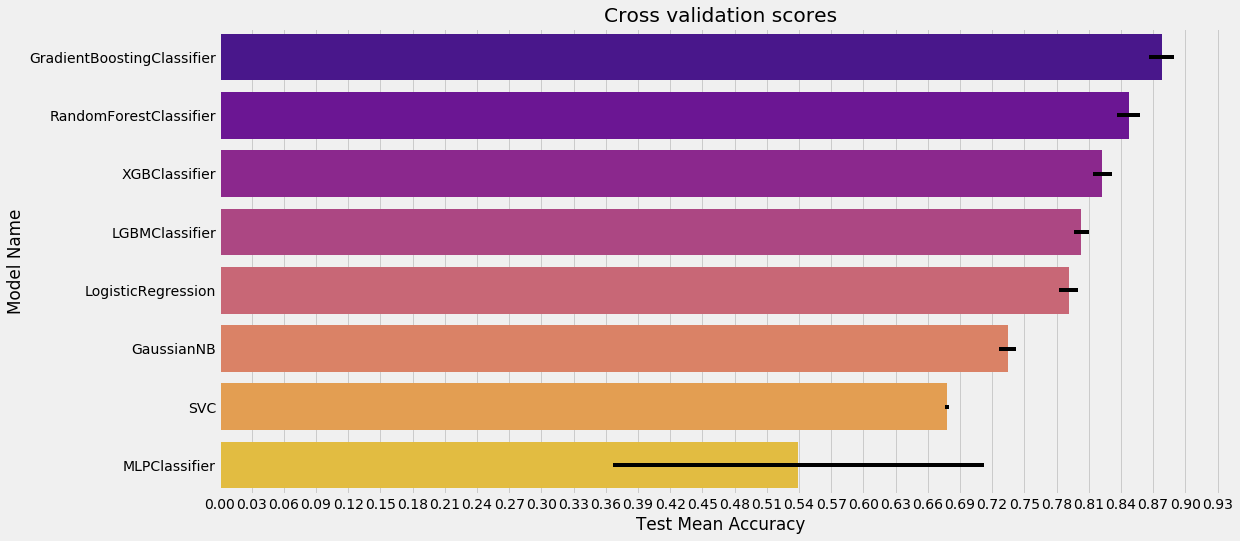

In [20]:
# Plotting model performances
model_barplot(raw_models, 32)

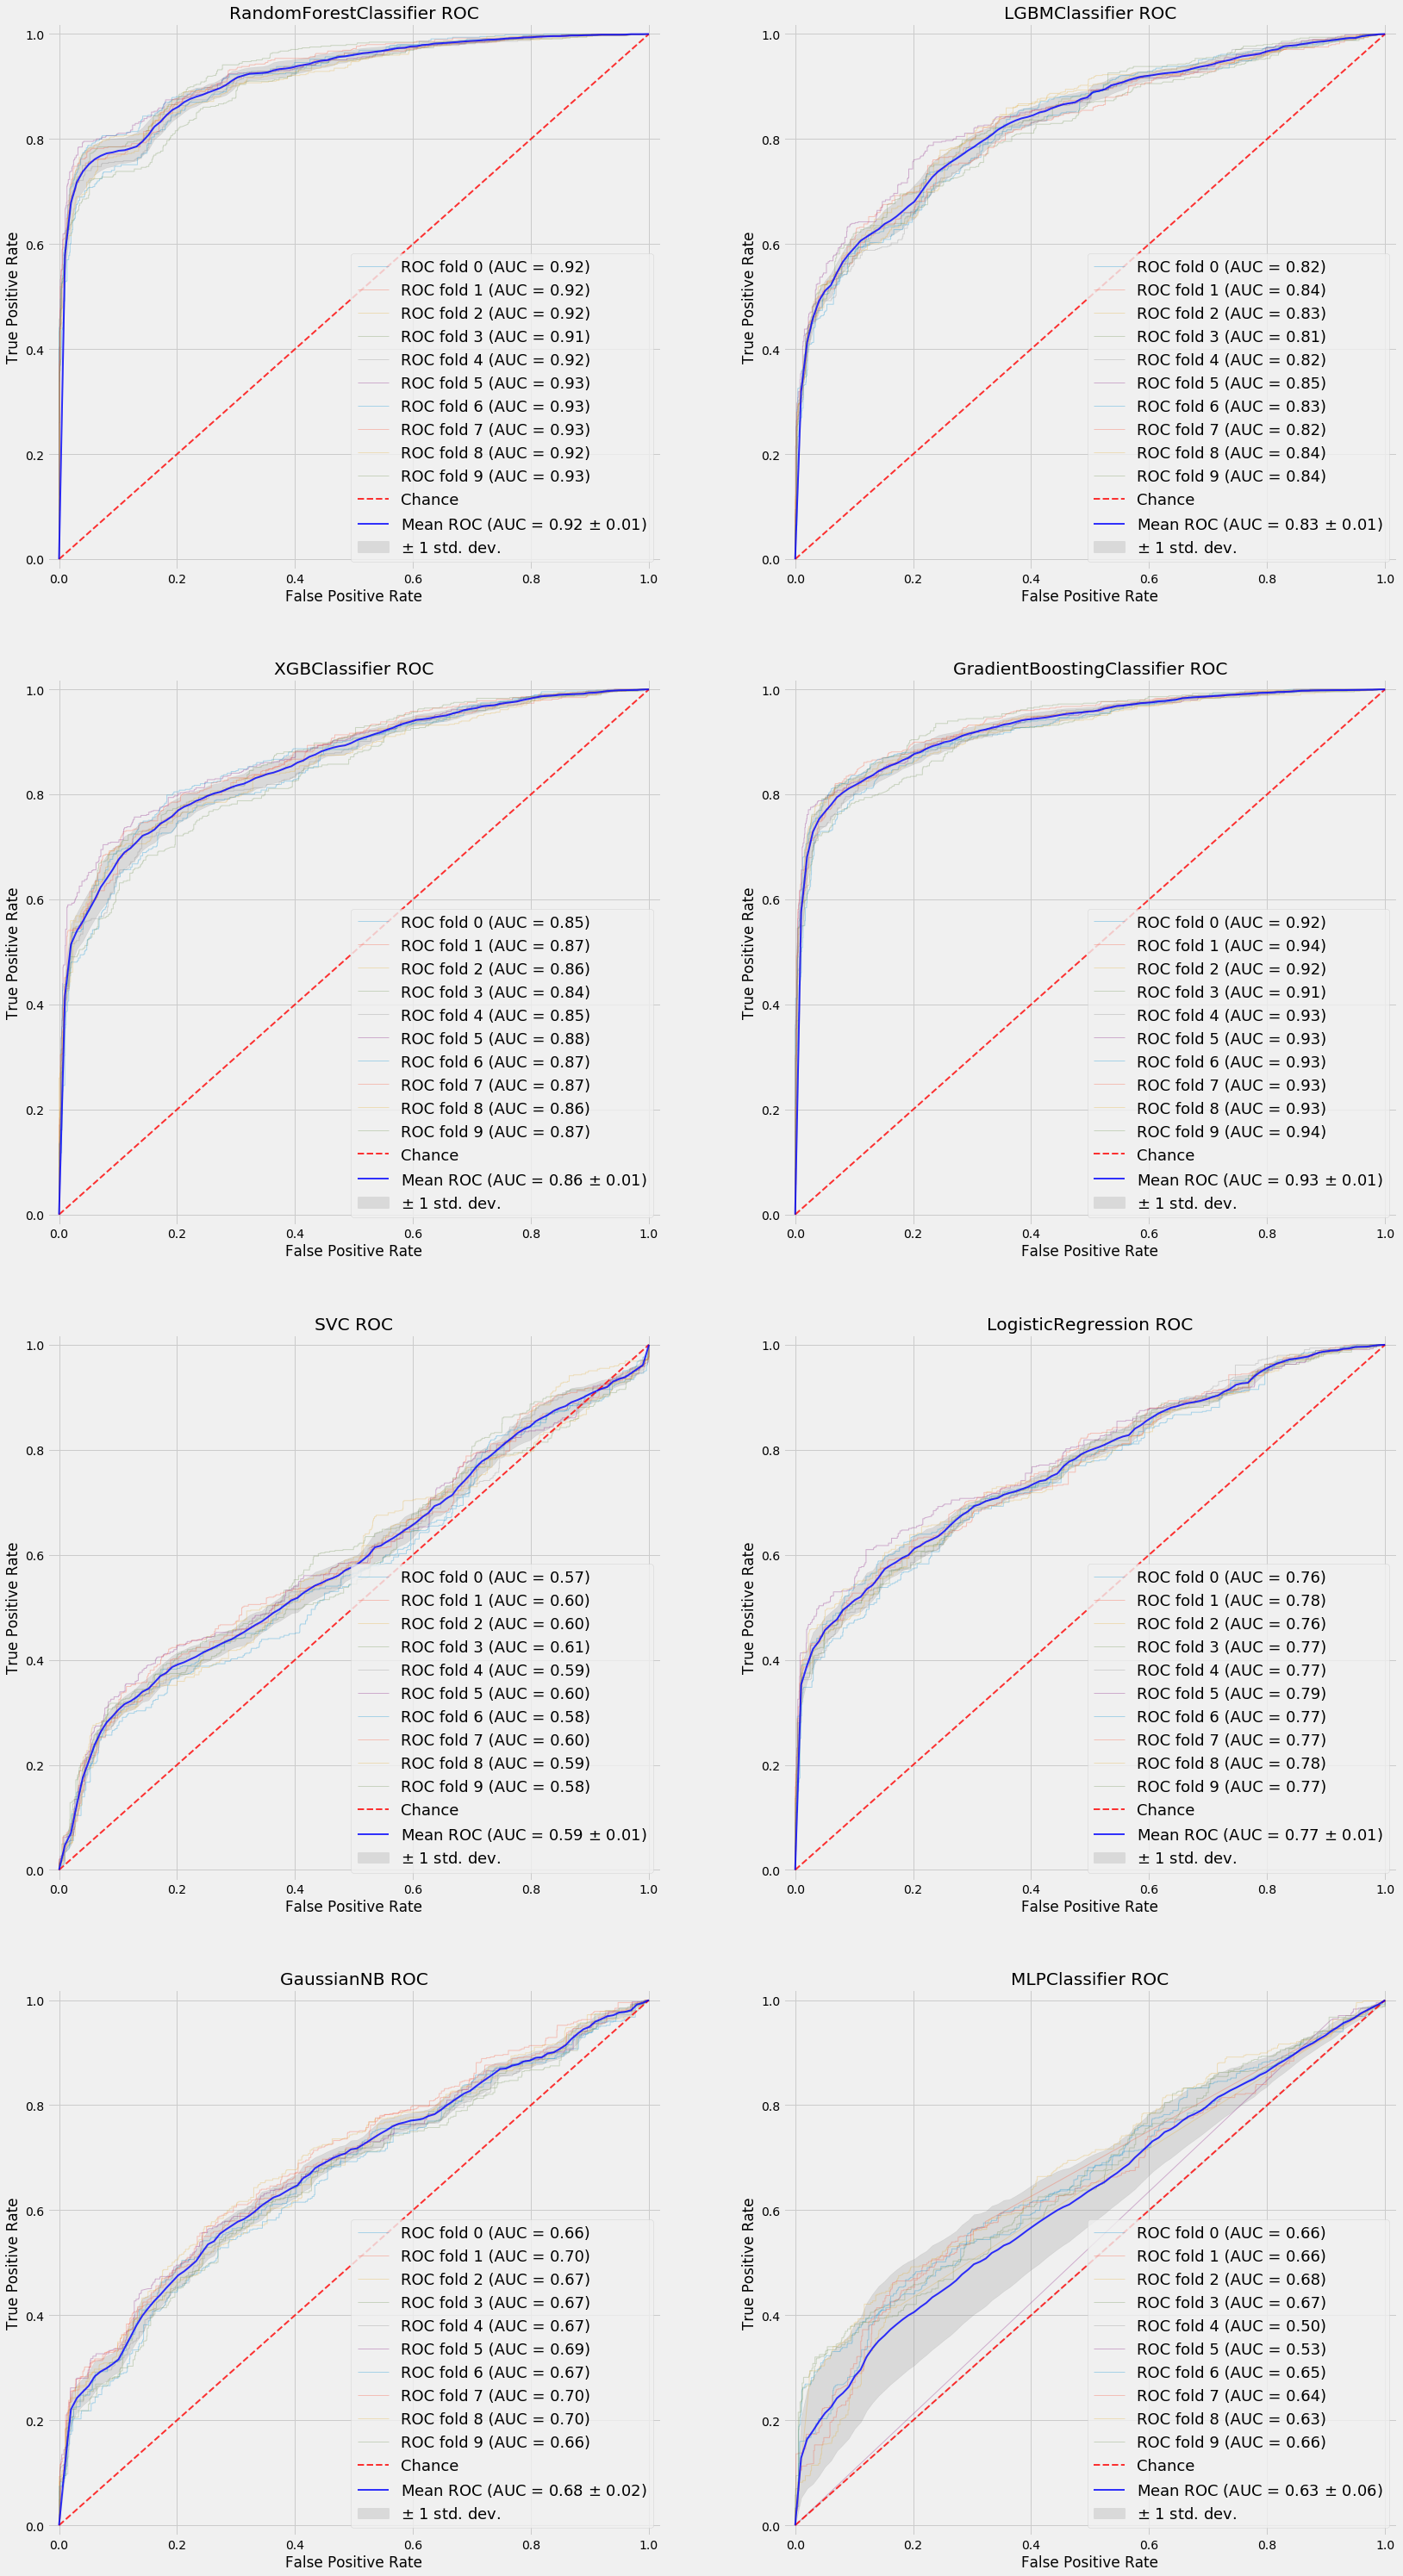

In [22]:
m_roc(estimators, cv, X, y)

/Users/cristobalza/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



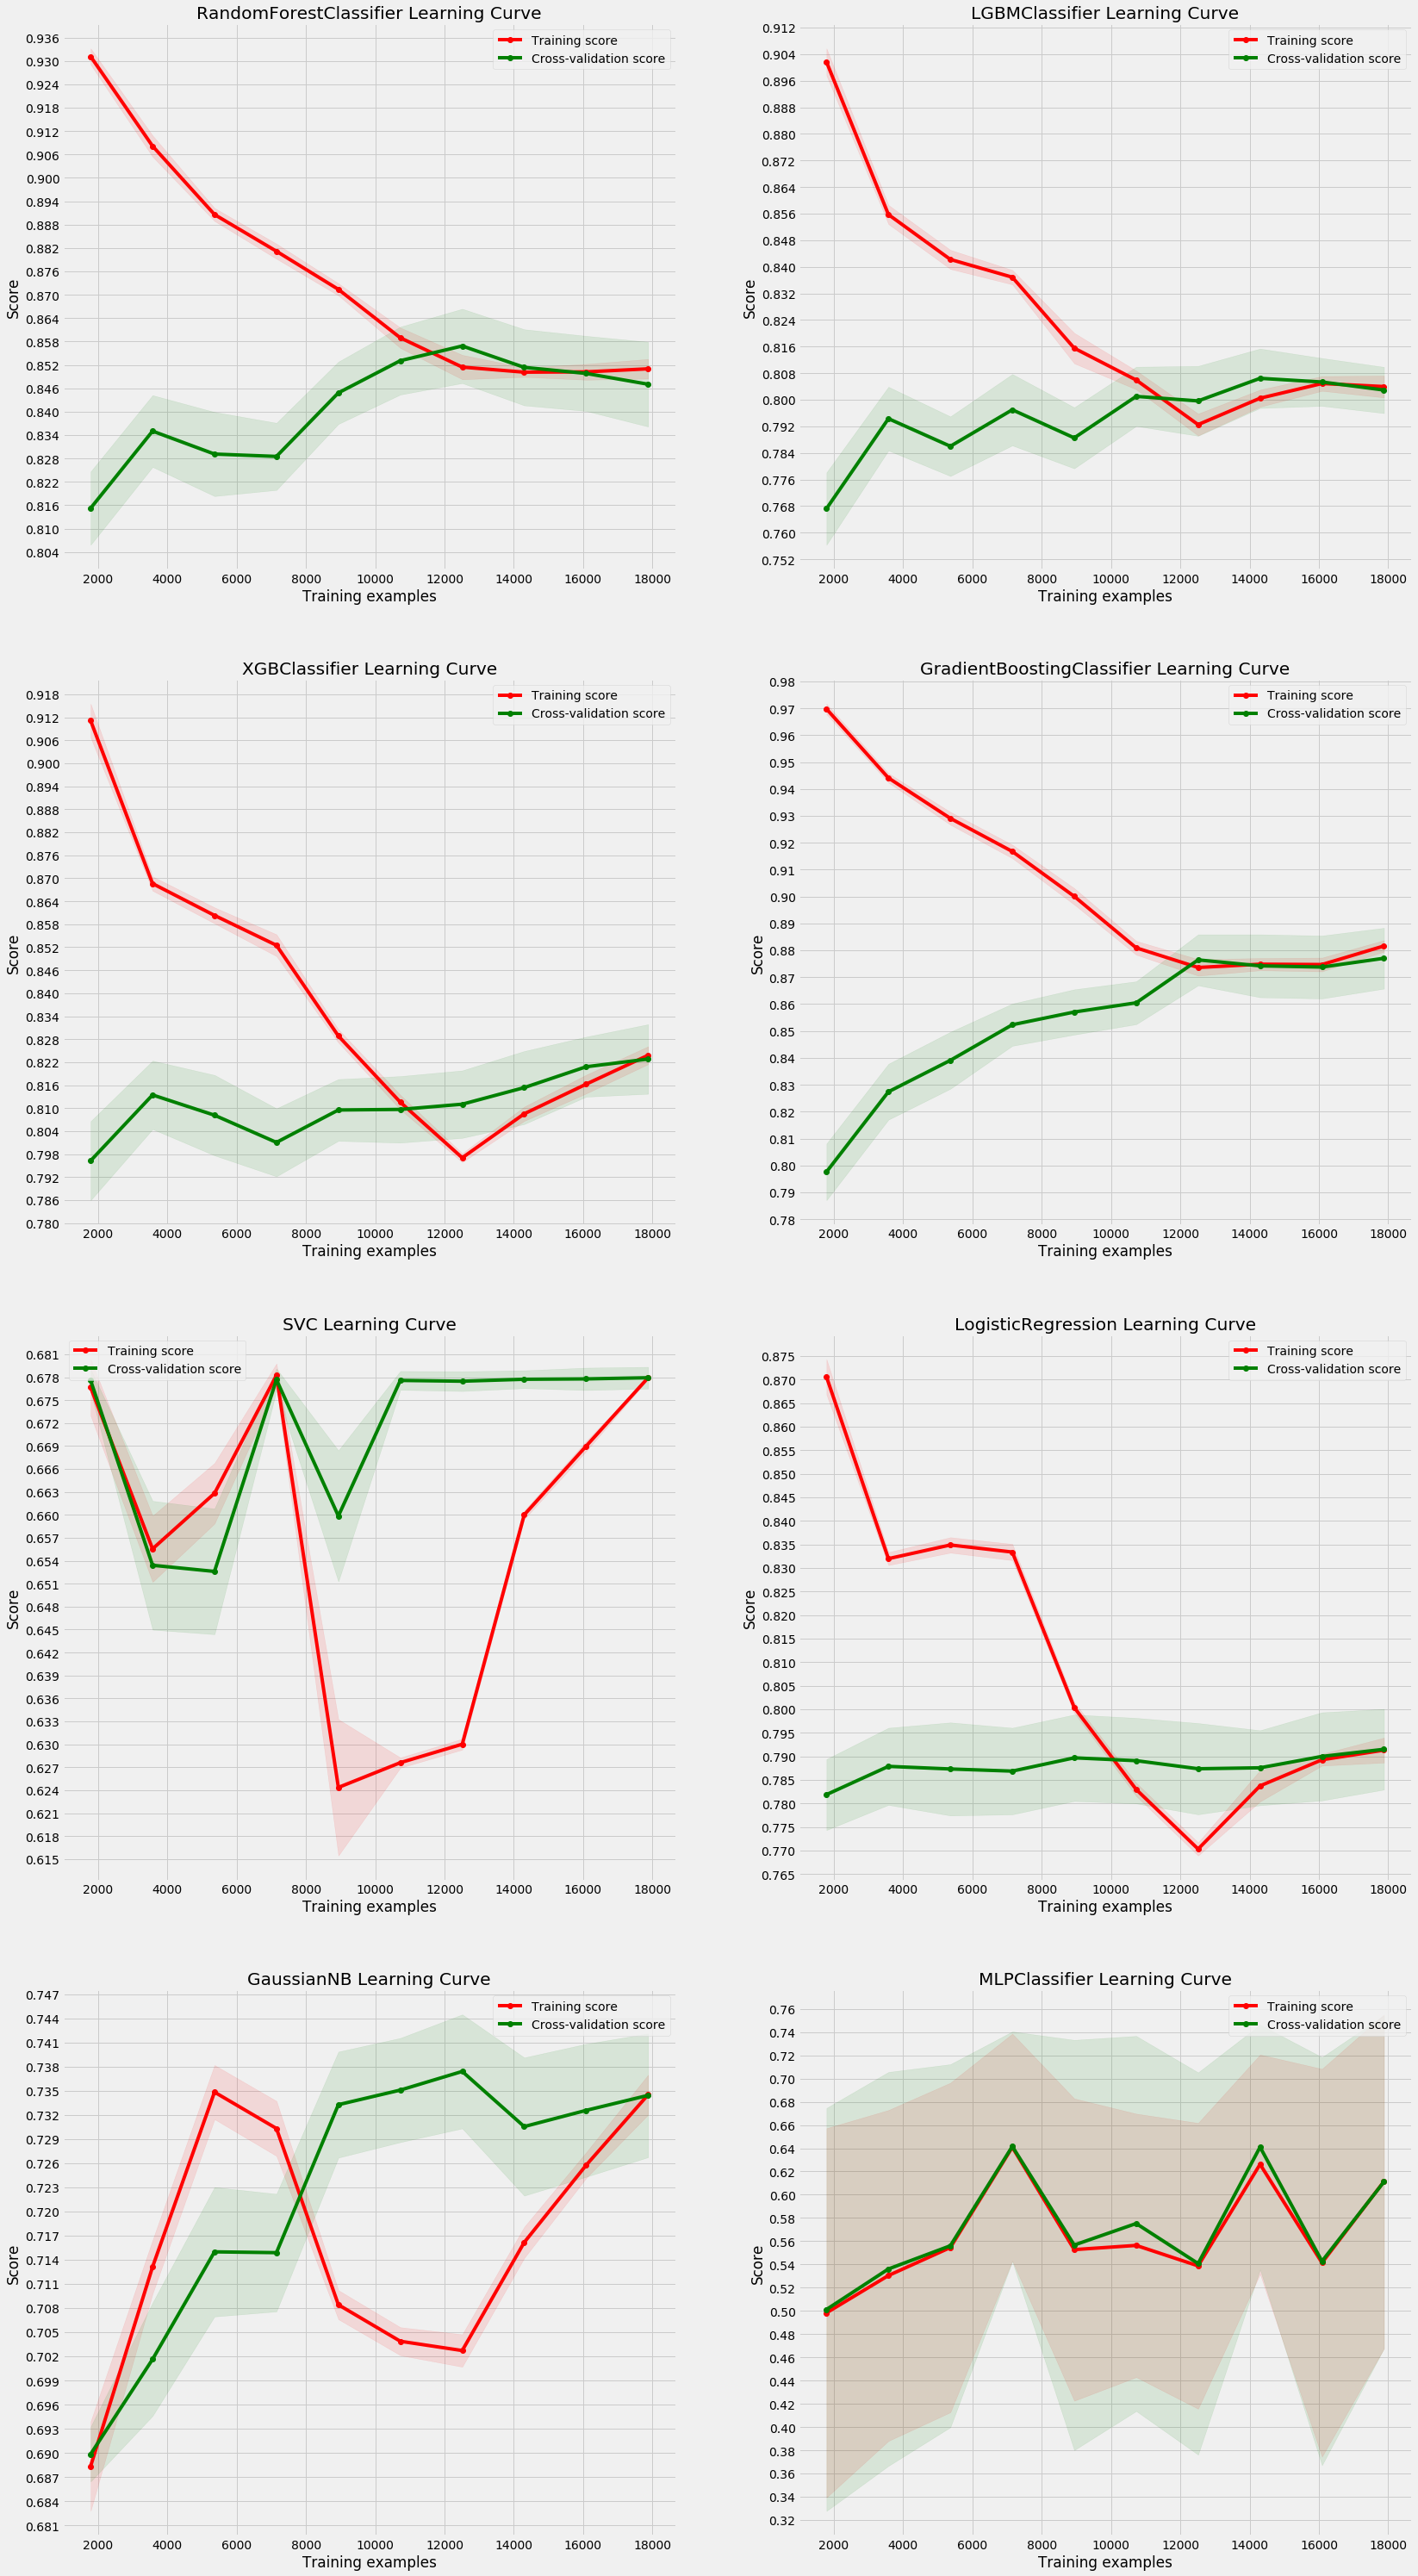

In [41]:
plot_learning_curve(estimators,
                    X,
                    y,
                    ylim=None,
                    cv=cv,
                    n_jobs=-1,
                    train_sizes=np.linspace(.1, 1.0, 10))

/Users/cristobalza/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



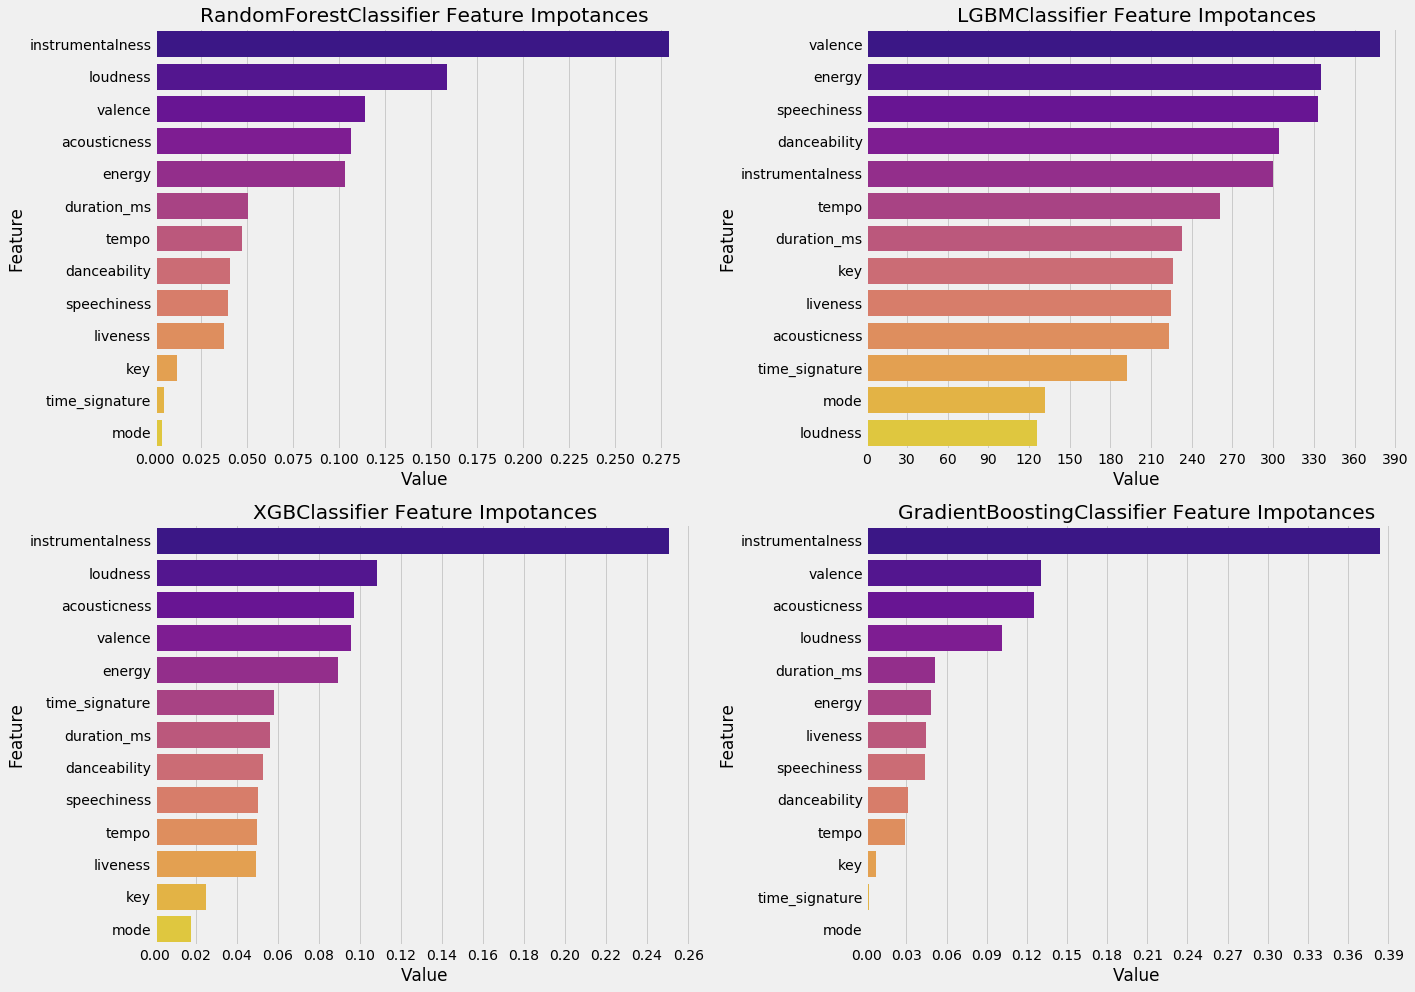

In [16]:
f_imp(estimators, X, y, 14)

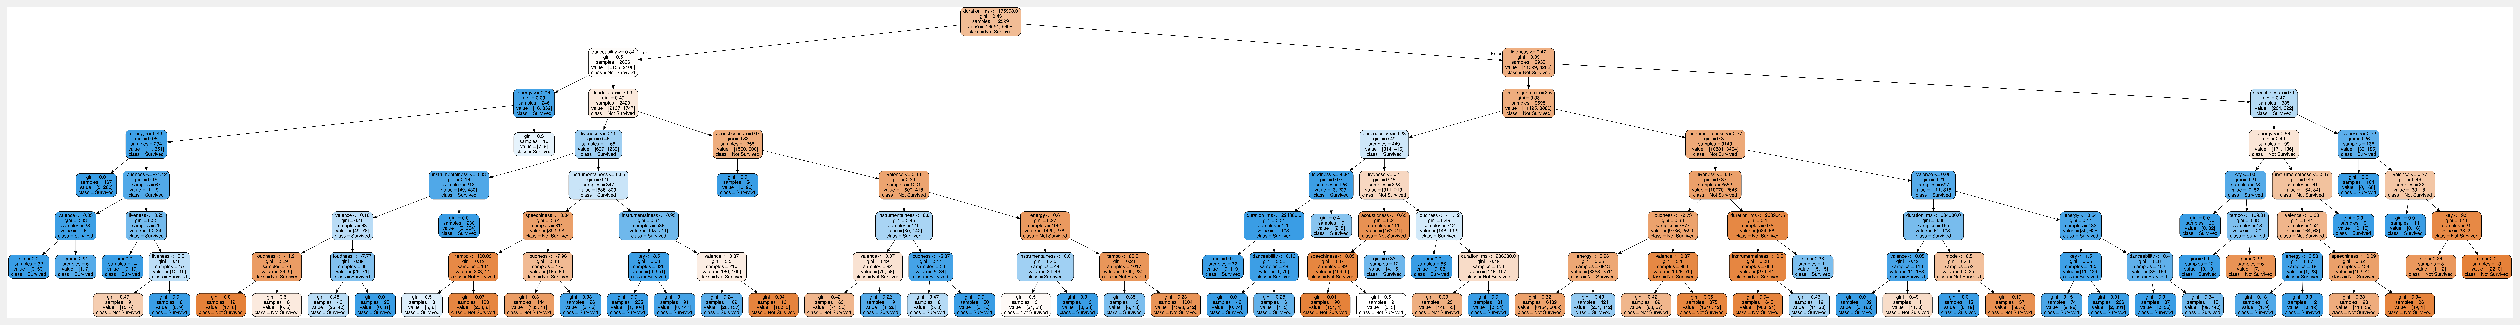

In [17]:
rf.fit(X, y)
# Extract first tree from random forest
estimator = rf.estimators_[0]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ['Not Survived','Survived'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in python
plt.figure(figsize = (40, 20))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');
plt.show();

In [19]:
X_sel, X_test_sel = f_selector(X, y, rf, 8)


Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
{'danceability': 3, 'energy': 1, 'key': 4, 'loudness': 1, 'mode': 6, 'speechiness': 1, 'acousticness': 1, 'instrumentalness': 1, 'liveness': 1, 'valence': 1, 'tempo': 1, 'duration_ms': 2, 'time_signature': 5}
Index(['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo'],
      dtype='object')
85.2% accuracy on test set.


In [20]:
# Build the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=2)),
])

# Fit the pipeline to the training data
X_sel_red = pipe.fit_transform(X_sel)
X_test_sel_red = pipe.transform(X_test_sel)

/Users/cristobalza/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



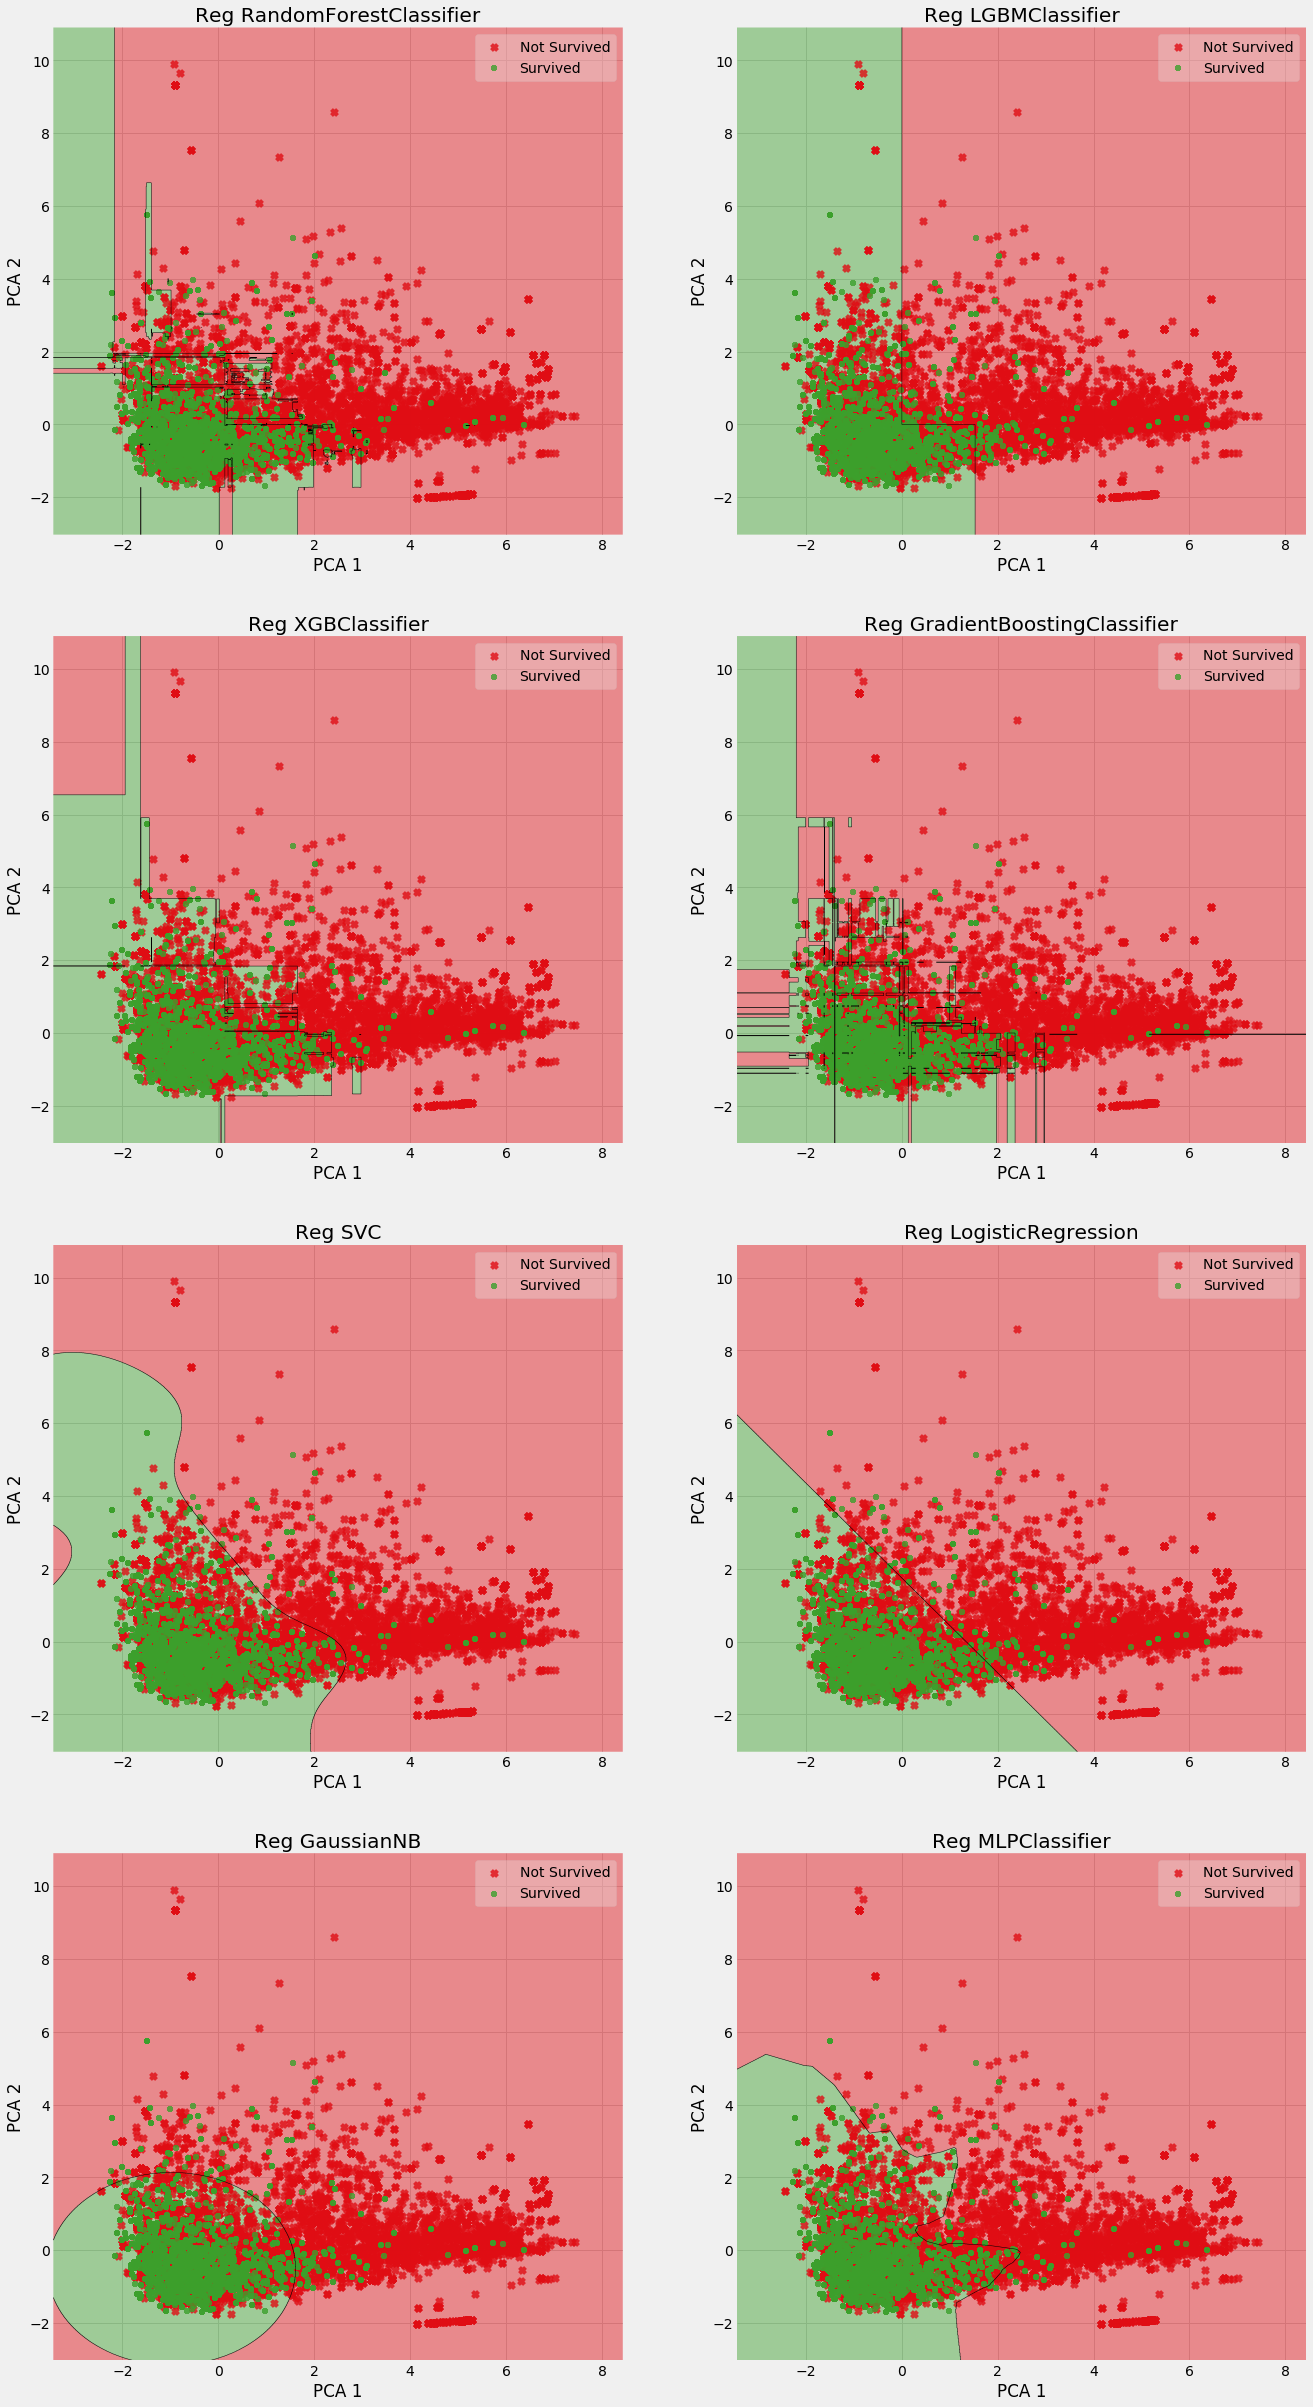

In [31]:
dec_regs(X_sel_red, y, estimators)

/Users/cristobalza/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/Users/cristobalza/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



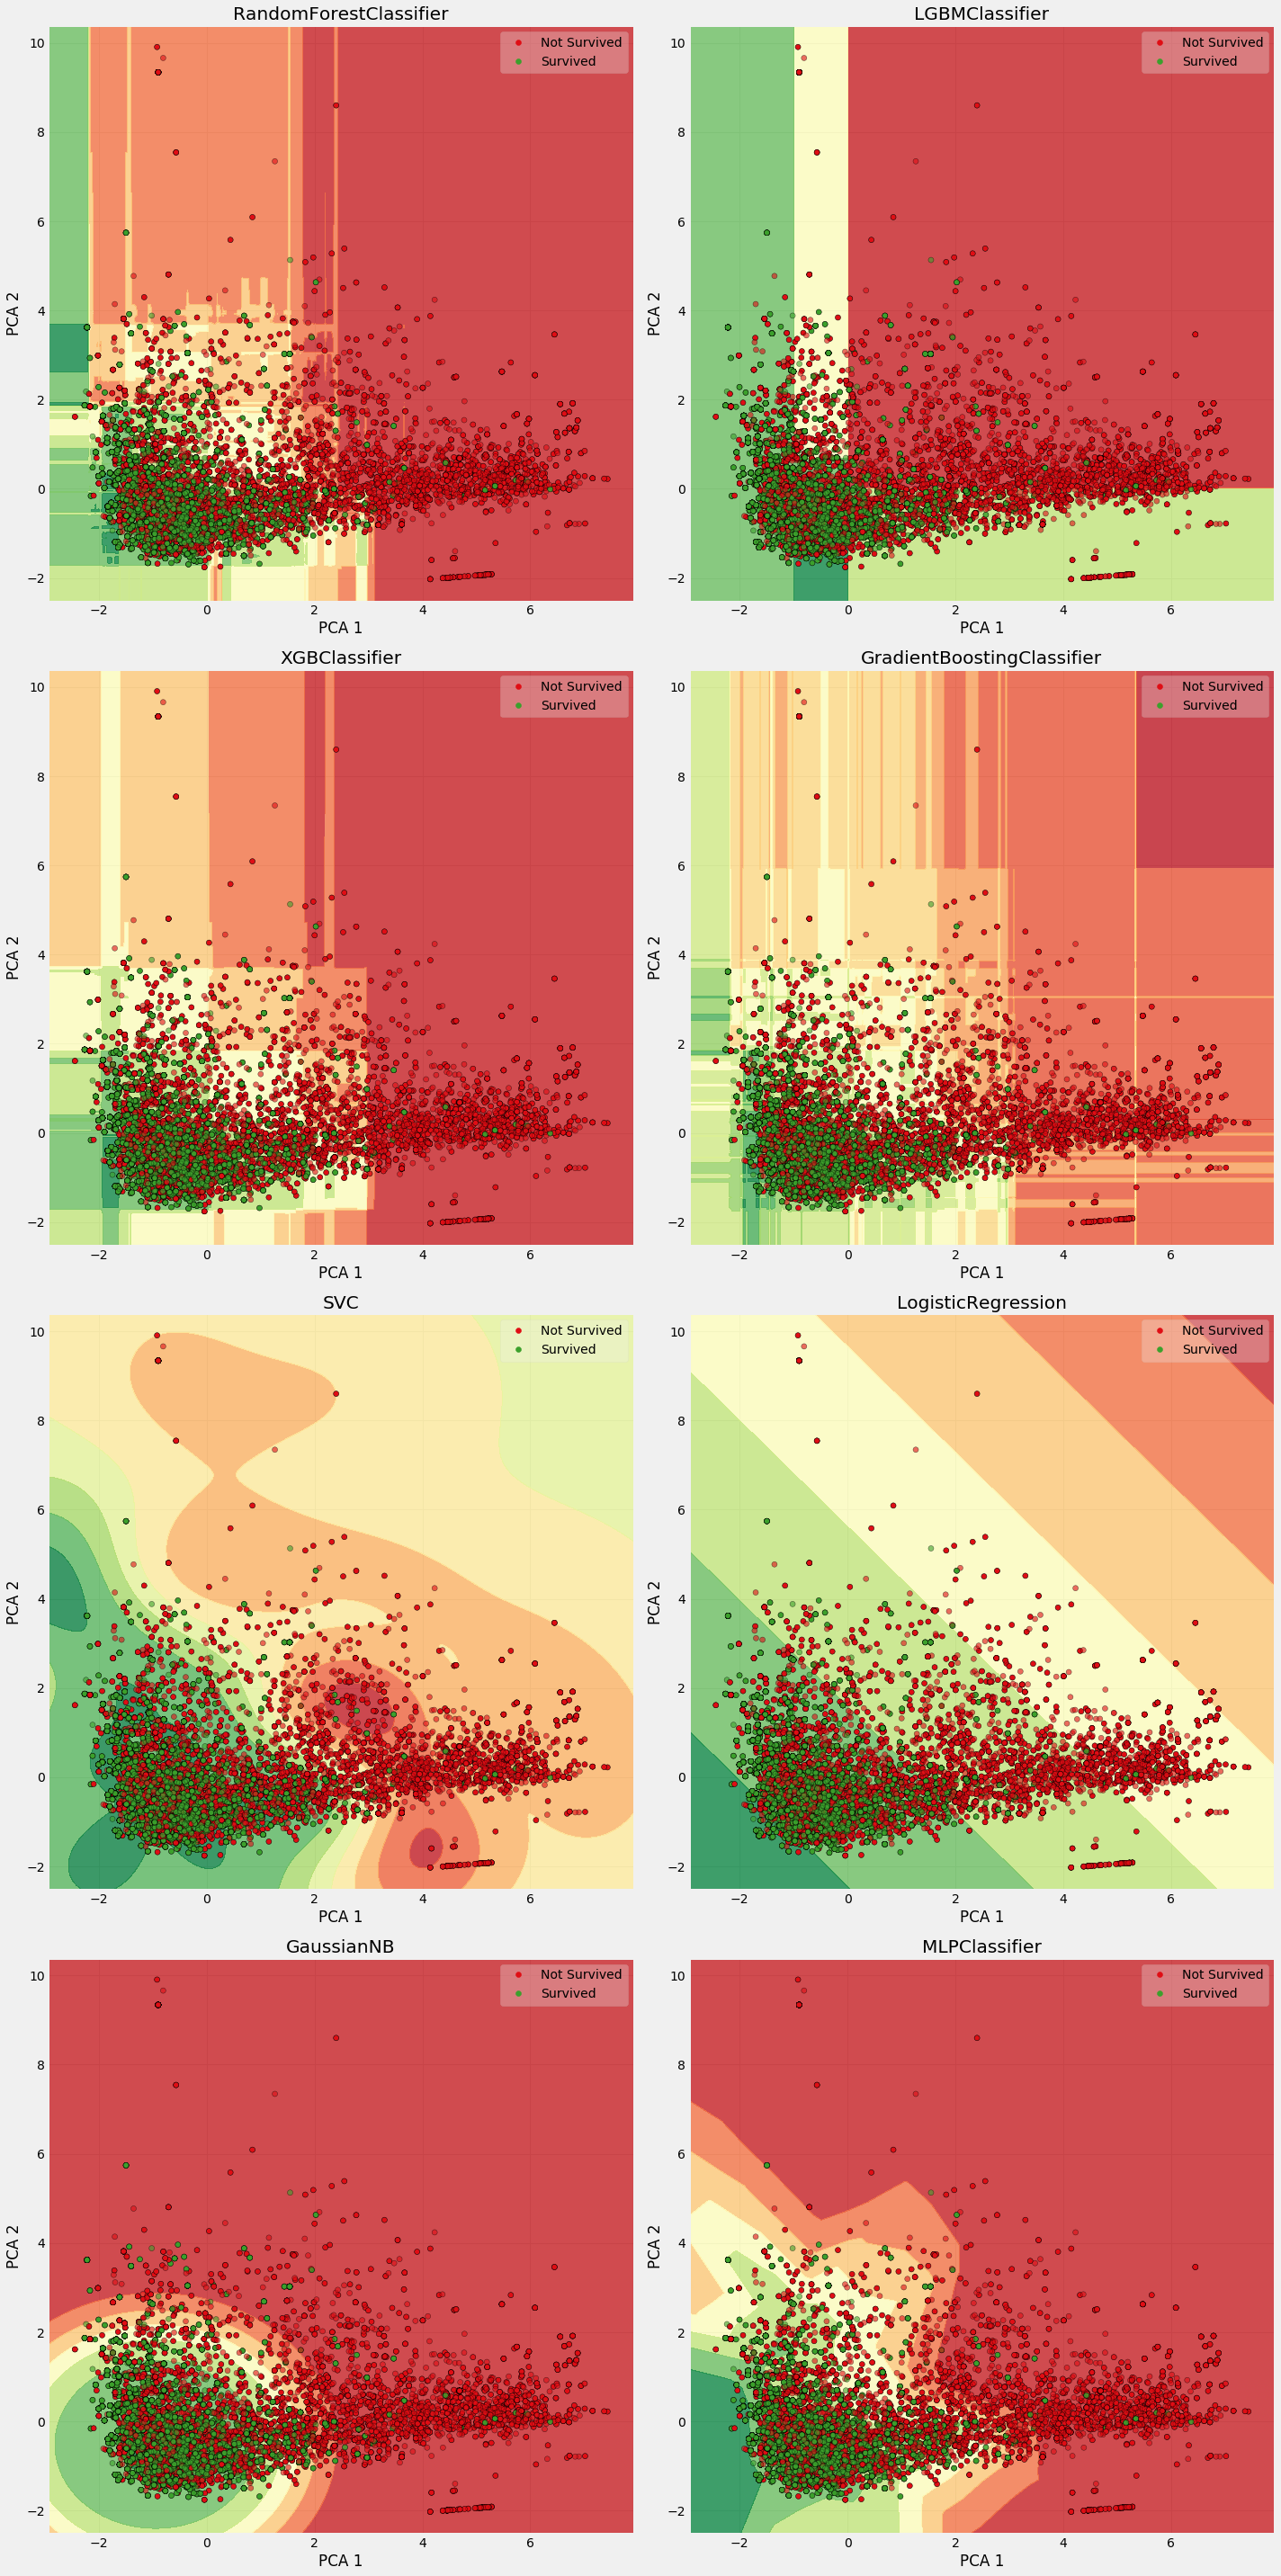

In [32]:
prob_reg(X_sel_red, y)

In [35]:
pca_models = model_check(X_sel_red, y, estimators, cv)
display(pca_models.style.background_gradient(cmap='summer_r'))

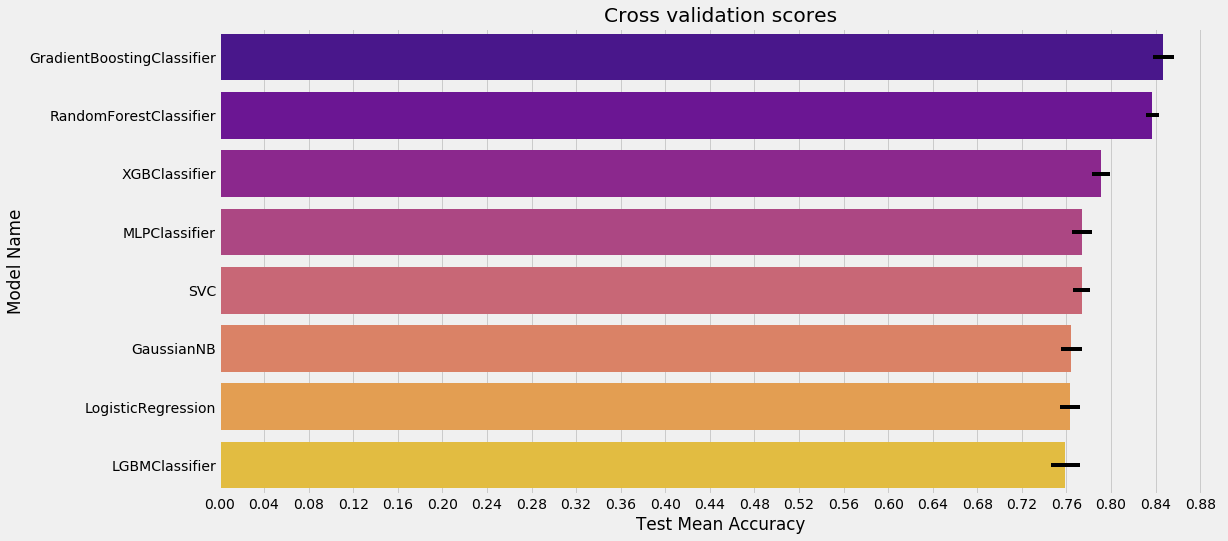

In [38]:
# Plotting model performances
model_barplot(pca_models, 24)

In [39]:
rand_model_full_data = gb.fit(X, y)
print(accuracy_score(y, rand_model_full_data.predict(X)))
y_pred = rand_model_full_data.predict(X_test)

0.8807270164132515


***

So far, we have worked with a small test set.